In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_columns import childhood, demographic, diagnosis, all
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN


In [197]:
init_df = pd.read_csv('./data/filtered_mental_health_data.csv')
df = init_df.copy()
# df_filtered = df[df.columns[~df.columns.str.match(r'^(D_|DSM_)')]]
df_filtered = df.copy()

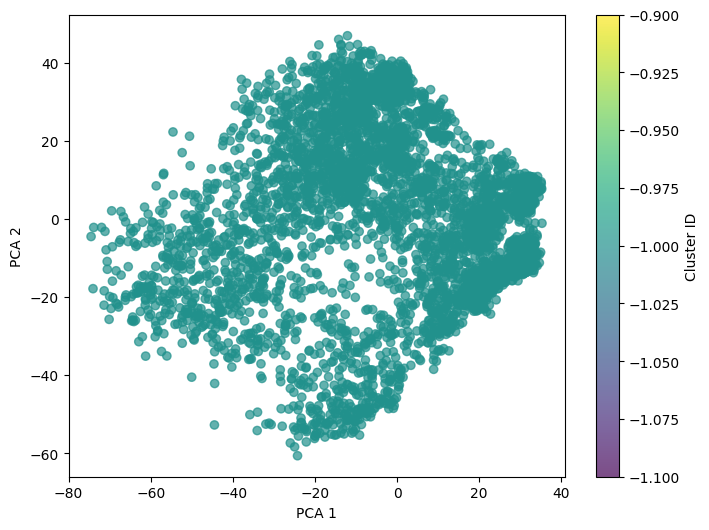

In [ ]:
dbscan_df = df_filtered.copy()
dbscan = DBSCAN(eps=.7, min_samples=10)
labels_db = dbscan.fit_predict(dbscan_df)

pca3 = PCA(n_components=2) 
X_pca = pca3.fit_transform(dbscan_df)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_db, cmap="viridis", alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()



/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


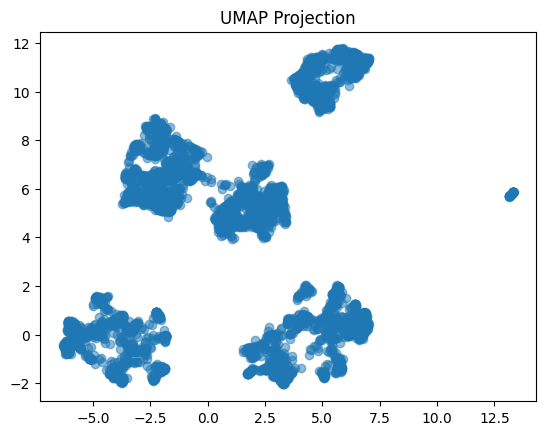

In [199]:

umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(df_filtered)

plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title("UMAP Projection")
plt.show()

/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


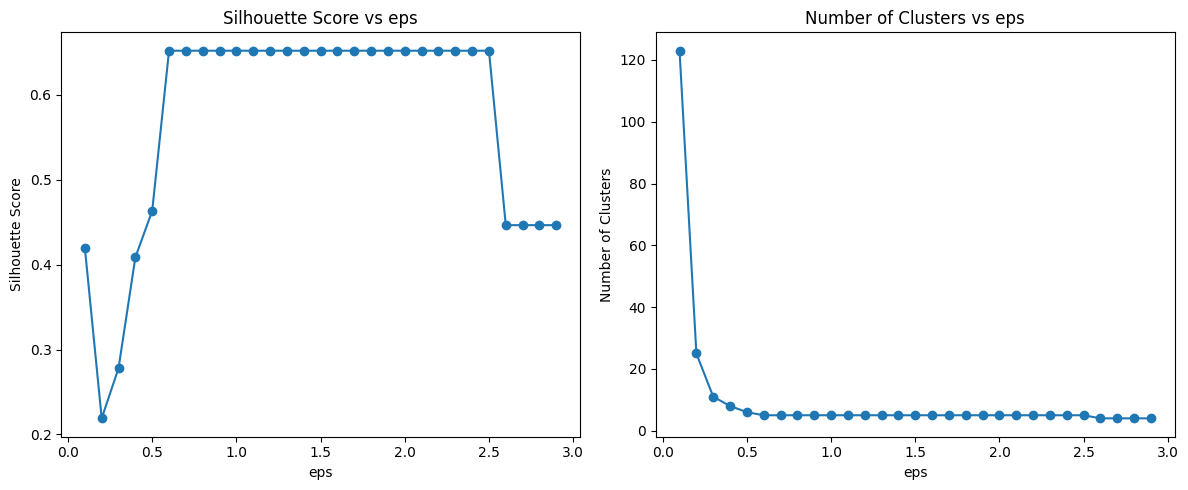

In [200]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_filtered)

eps_values = np.arange(0.1, 3.0, 0.1)
silhouette_scores = []
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_umap)

    if len(set(labels)) > 1 and len(set(labels)) < len(X_umap):
        score = silhouette_score(X_umap[labels != -1], labels[labels != -1])
    else:
        score = -1 

    silhouette_scores.append(score)
    n_clusters_list.append(len(set(labels)) - (1 if -1 in labels else 0))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eps_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs eps')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title('Number of Clusters vs eps')
plt.xlabel('eps')
plt.ylabel('Number of Clusters')

plt.tight_layout()
plt.show()

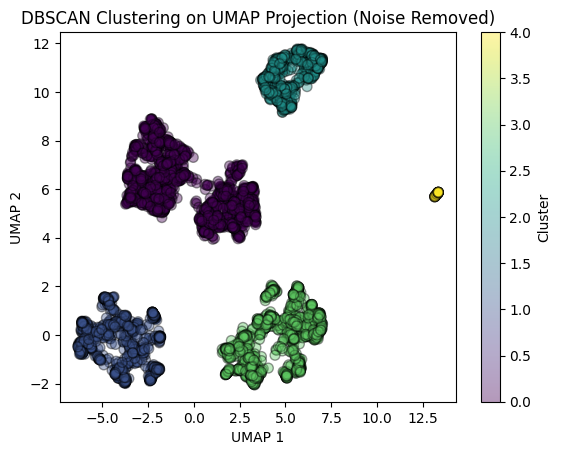

In [222]:
dbscan5 = DBSCAN(eps=.6, min_samples=5)
labels5 = dbscan5.fit_predict(X_umap)

mask = labels5 != -1
X_umap_filtered5 = X_umap[mask]
labels5_filtered = labels5[mask]

plt.scatter(X_umap_filtered5[:, 0], X_umap_filtered5[:, 1], c=labels5_filtered, cmap='viridis', s=50, alpha=0.4, edgecolor='k',label='Data Points')
plt.title("DBSCAN Clustering on UMAP Projection (Noise Removed)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

In [220]:
sil_coeff = silhouette_score(X_umap,labels5)
print("Silhouette Coefficient:", round(sil_coeff, 3))

score = davies_bouldin_score(X_umap, labels5)
print("Davis - Bouldin score:",score)

Silhouette Coefficient: 0.652
Davis - Bouldin score: 0.45250730931544003


In [221]:
eps_values = np.linspace(0.1, 2.0, 20)  # adjust range to your dataset
results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10).fit(X_umap)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters > 1:
        sil = silhouette_score(X_umap, labels)
        dbi = davies_bouldin_score(X_umap, labels)
    else:
        sil = np.nan
        dbi = np.nan
    
    results.append((eps, n_clusters, sil, dbi))

df_results = pd.DataFrame(results, columns=['eps', 'n_clusters', 'silhouette', 'davies_bouldin'])
print(df_results)

    eps  n_clusters  silhouette  davies_bouldin
0   0.1          96    0.197892        1.461232
1   0.2          35    0.374541        1.080389
2   0.3          14    0.402932        1.119023
3   0.4           9    0.387747        1.089913
4   0.5           7    0.530174        0.570808
5   0.6           6    0.670752        0.403910
6   0.7           5    0.652011        0.452507
7   0.8           5    0.652011        0.452507
8   0.9           5    0.652011        0.452507
9   1.0           5    0.652011        0.452507
10  1.1           5    0.652011        0.452507
11  1.2           5    0.652011        0.452507
12  1.3           5    0.652011        0.452507
13  1.4           5    0.652011        0.452507
14  1.5           5    0.652011        0.452507
15  1.6           5    0.652011        0.452507
16  1.7           5    0.652011        0.452507
17  1.8           5    0.652011        0.452507
18  1.9           5    0.652011        0.452507
19  2.0           5    0.652011        0

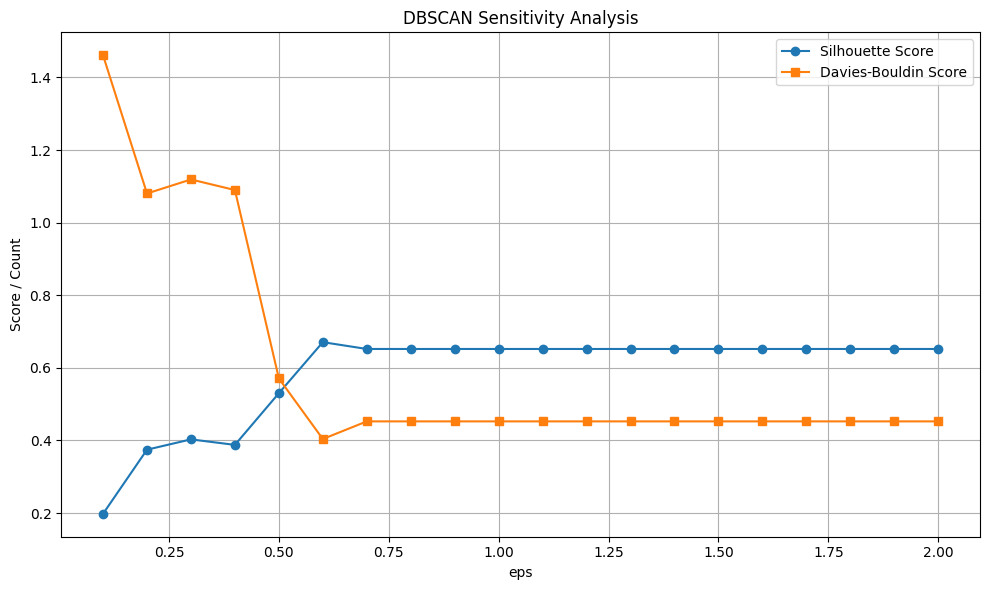

In [223]:
plt.figure(figsize=(10, 6))

plt.plot(df_results['eps'], df_results['silhouette'], label='Silhouette Score', marker='o')
plt.plot(df_results['eps'], df_results['davies_bouldin'], label='Davies-Bouldin Score', marker='s')

plt.xlabel('eps')
plt.ylabel('Score / Count')
plt.title('DBSCAN Sensitivity Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

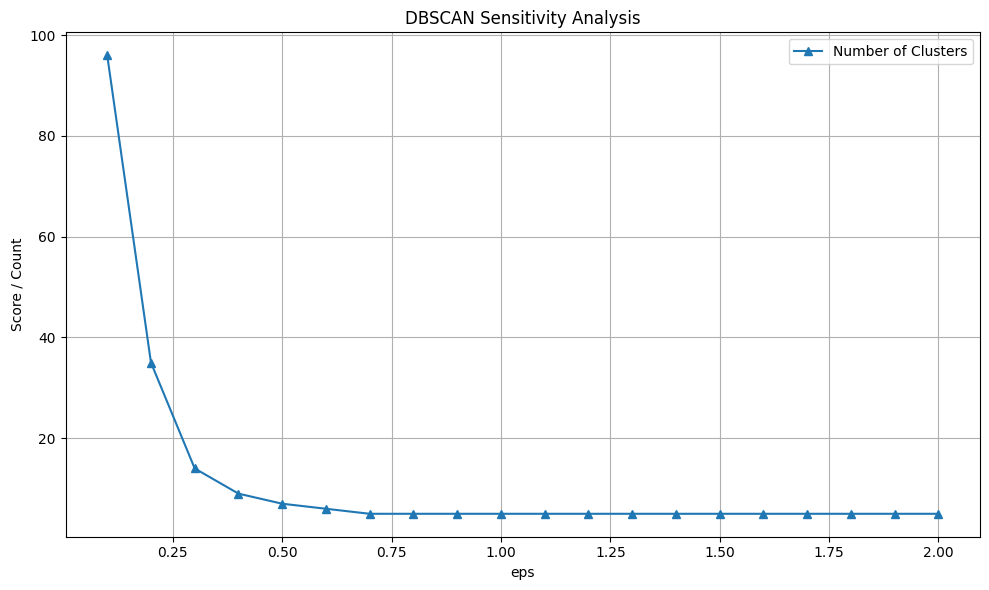

In [205]:
plt.figure(figsize=(10, 6))

plt.plot(df_results['eps'], df_results['n_clusters'], label='Number of Clusters', marker='^')

plt.xlabel('eps')
plt.ylabel('Score / Count')
plt.title('DBSCAN Sensitivity Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis

In [224]:
analysis_df = init_df.copy()
analysis_df['cluster'] = labels5
analysis_df

,M1,M18,M18B2,M18B3,M47,IR2,IR4,IR20,IR20B4,IR21,...,EMP_WORK,EMP_STU,EMP_HM,EMP_RET,EMP_OTH,INC_LO,INC_LOAVG,INC_HIAVG,INC_HI,cluster
0,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,0
1,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,1
2,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,1,0,0,0,1
3,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,0,0,0,0,1,1,0,0,0,2
4,-7,-7,-7,-7,-7,5,-7,-7,-7,-7,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,1,1,-7,-7,5,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,1
4997,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,1
4998,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,0,1,1
4999,-7,1,-7,-7,5,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,2


In [225]:
demo = demographic()
demo_cols = [d for d in demo if d in analysis_df.columns]
diag = diagnosis()
diag_cols = [d for d in diag if d in analysis_df.columns]
child = childhood()
child_cols = [c for c in child if c in analysis_df.columns]

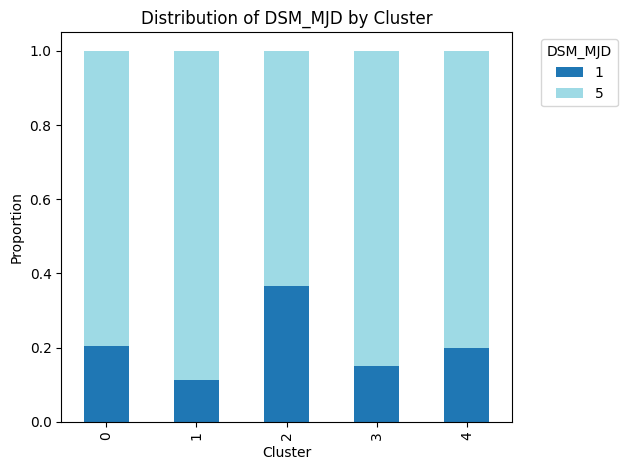

In [226]:
feature = 'DSM_MJD'
crosstab = pd.crosstab(analysis_df['cluster'], analysis_df[feature], normalize='index')

crosstab.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f"Distribution of {feature} by Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [210]:
def cluster_visual(columns,df,cluster_co_nm = 'cluster'):
    n_features = len(columns)
    n_cols = 4  
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(columns):
        ax = axes[i]
        crosstab = pd.crosstab(df[cluster_co_nm], df[feature], normalize='index')
        crosstab.plot(kind='bar', stacked=True, colormap='tab20', ax=ax, legend=False)
        ax.set_title(f"{feature}")
        ax.set_ylabel("Proportion")
        ax.set_xlabel("Cluster")

    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    handles, labels = ax.get_legend_handles_labels()
    fig.tight_layout(rect=[0, 0, 0.85, 1]) 

    plt.show()

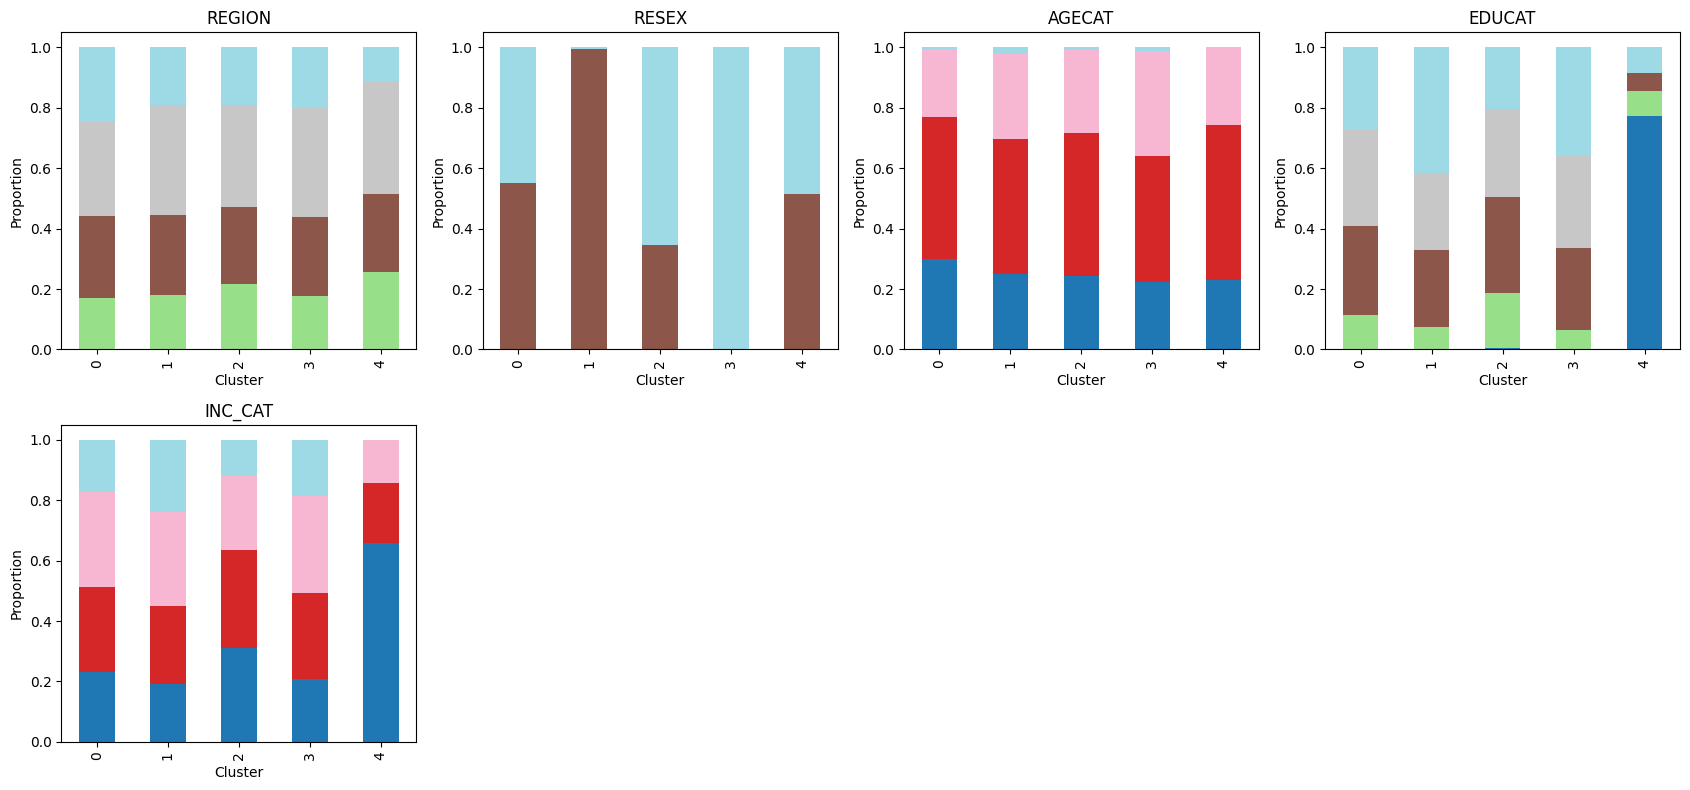

In [227]:
cluster_visual(demo_cols,analysis_df)

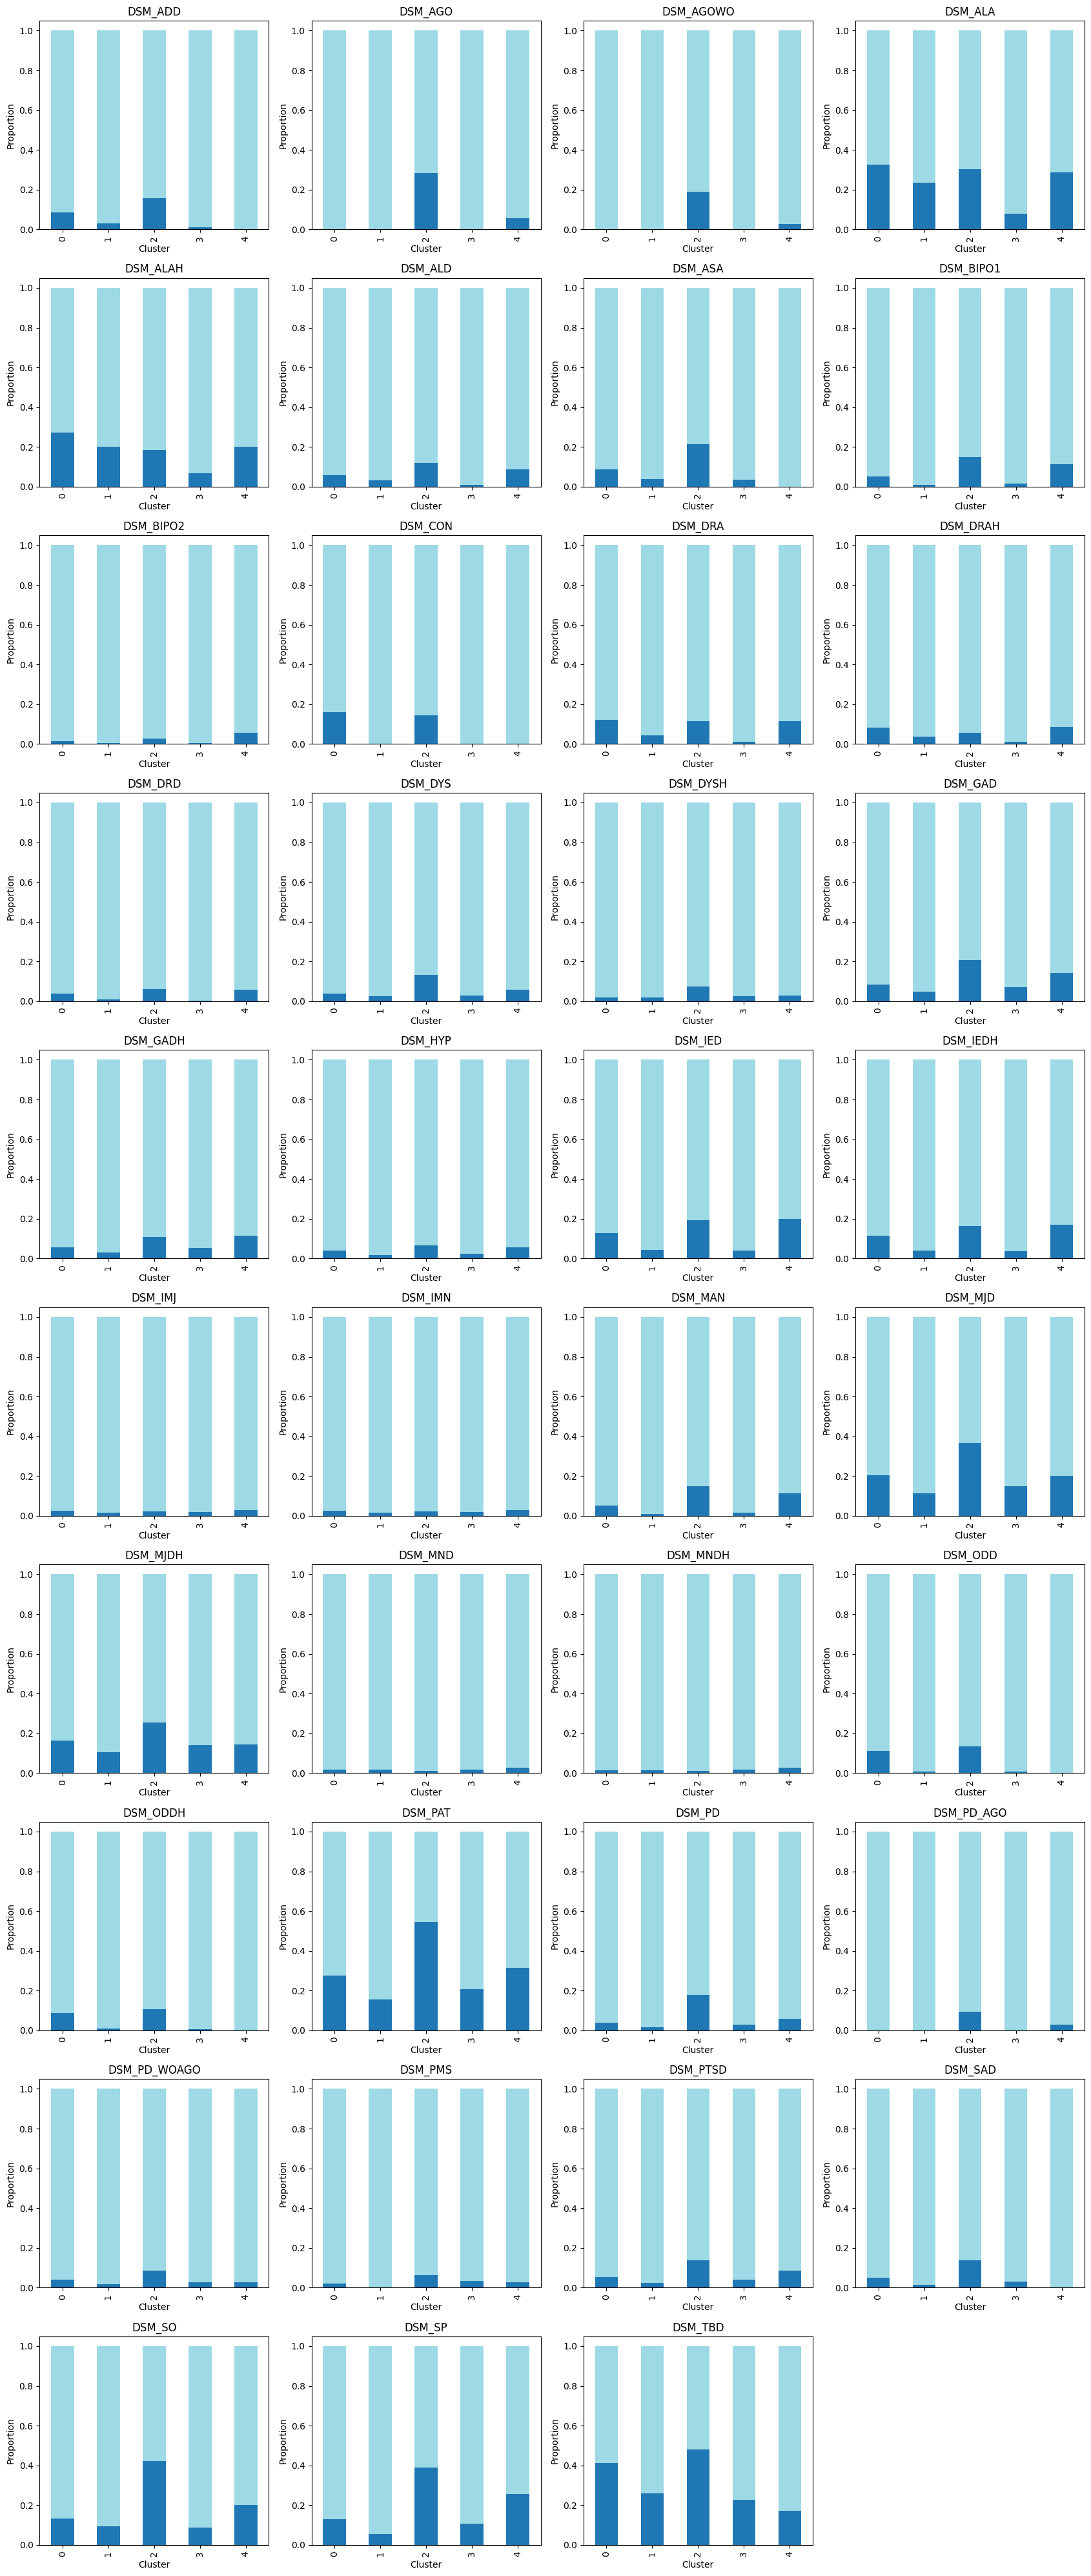

In [212]:
cluster_visual(diag_cols,analysis_df)

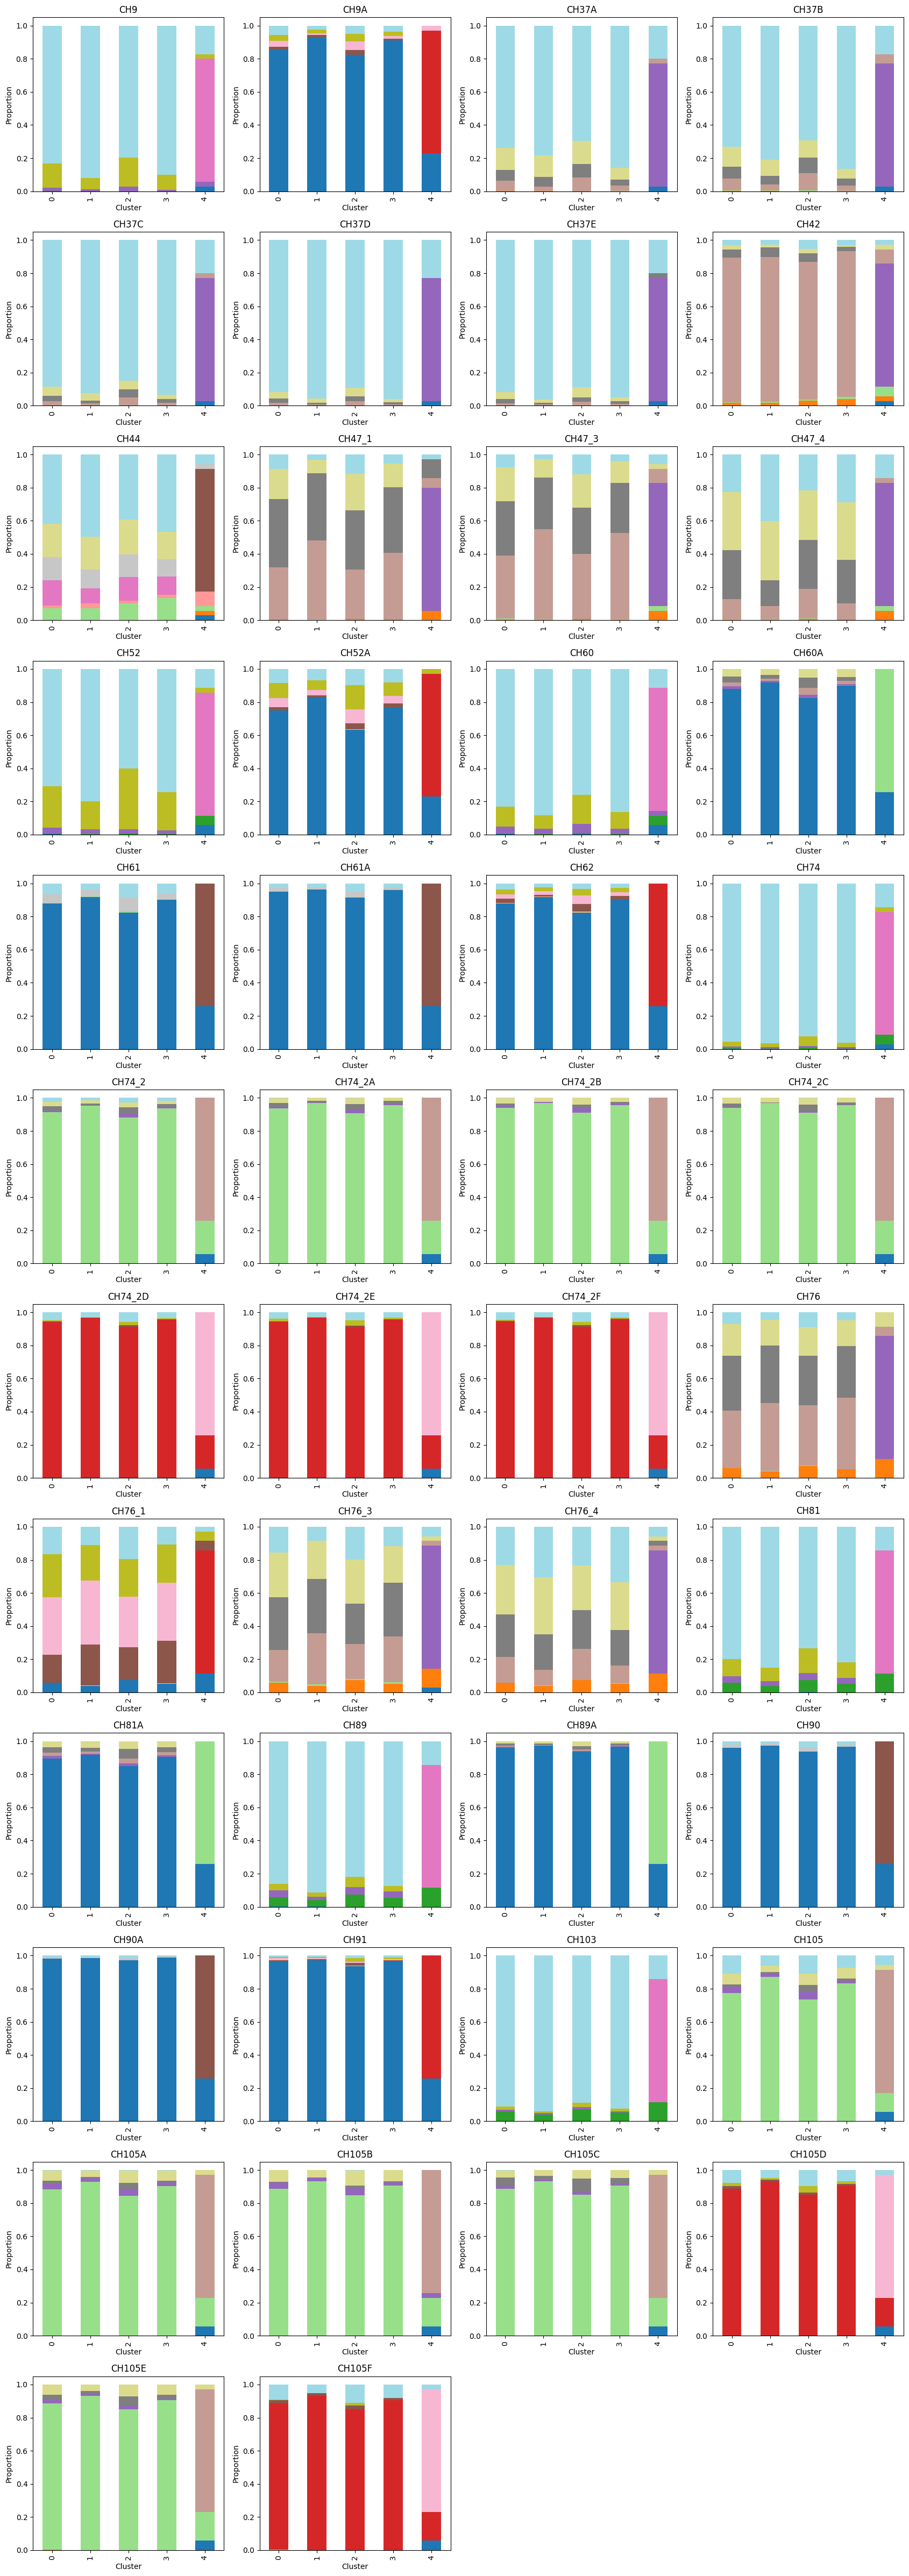

In [213]:
cluster_visual(child_cols,analysis_df)

In [214]:
cluster4_df = analysis_df[analysis_df['cluster'] == 4]
cluster4_ch_df = cluster4_df[child_cols]

for c in cluster4_ch_df.columns:
    s = cluster4_ch_df[c]
    print(c,s.mode().values)


CH9 [-4]
CH9A [-4]
CH37A [-4]
CH37B [-4]
CH37C [-4]
CH37D [-4]
CH37E [-4]
CH42 [-4]
CH44 [-4]
CH47_1 [-4]
CH47_3 [-4]
CH47_4 [-4]
CH52 [-4]
CH52A [-4]
CH60 [-4]
CH60A [-4]
CH61 [-4]
CH61A [-4]
CH62 [-4]
CH74 [-4]
CH74_2 [-4]
CH74_2A [-4]
CH74_2B [-4]
CH74_2C [-4]
CH74_2D [-4]
CH74_2E [-4]
CH74_2F [-4]
CH76 [-4]
CH76_1 [-4]
CH76_3 [-4]
CH76_4 [-4]
CH81 [-4]
CH81A [-4]
CH89 [-4]
CH89A [-4]
CH90 [-4]
CH90A [-4]
CH91 [-4]
CH103 [-4]
CH105 [-4]
CH105A [-4]
CH105B [-4]
CH105C [-4]
CH105D [-4]
CH105E [-4]
CH105F [-4]


In [229]:
cluster3_df = analysis_df[analysis_df['cluster'] == 3]
cluster3_demo_df = cluster3_df[demo_cols]
cluster3_demo_df

for c in cluster3_demo_df.columns:
    s = cluster3_demo_df[c]
    print(c,s.mode().values)

# - REGION [3] -- South
# - RESEX [2] -- Women
# - AGECAT [2] -- 35-49
# - EDUCAT [4] -- 16 or more years
# - INC_CAT [3] -- $25,750 - $51-499

REGION [3]
RESEX [2]
AGECAT [2]
EDUCAT [4]
INC_CAT [3]


In [230]:
cluster3_demo_df['RESEX'].value_counts()

RESEX
2    1250
Name: count, dtype: int64

In [231]:
cluster3_df['DSM_MJD'].value_counts()

DSM_MJD
5    1063
1     187
Name: count, dtype: int64

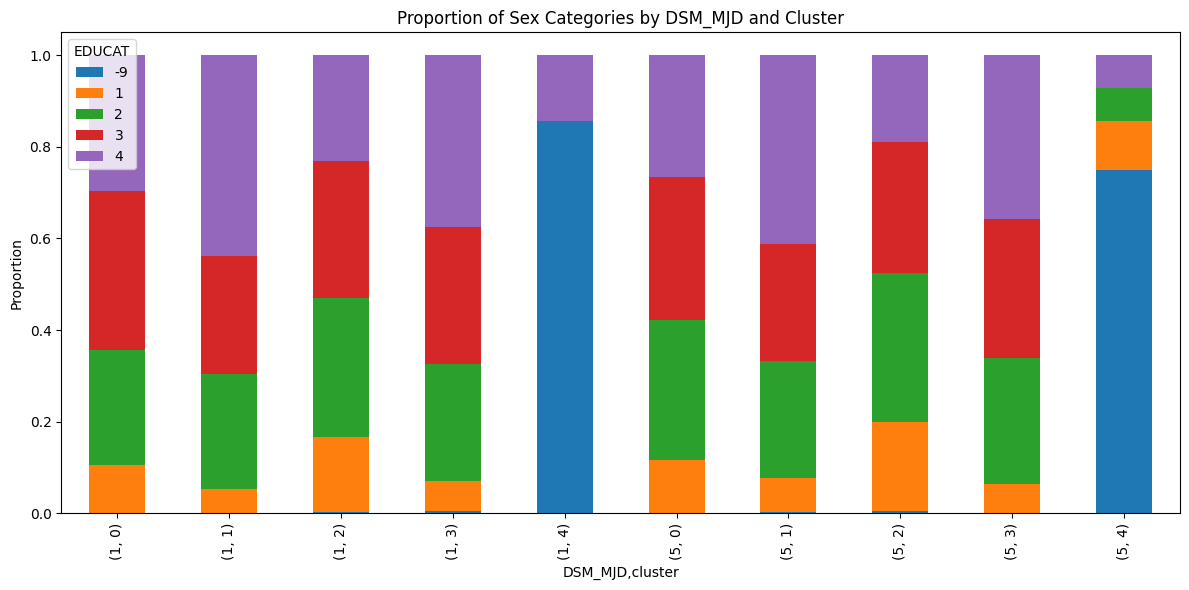

EDUCAT           -9    1    2    3    4
DSM_MJD cluster                        
1       0         0   41   98  135  115
        1         0    6   28   29   49
        2         1   49   91   90   69
        3         1   12   48   56   70
        4         6    0    0    0    1
5       0         0  177  463  473  405
        1         2   66  223  225  361
        2         2  102  169  149   98
        3         0   67  293  322  381
        4        21    3    2    0    2

In [218]:
list = demo_cols + ['DSM_MJD', 'cluster']
df_demo = analysis_df[list].copy()

# results = {}
# for col in demo_cols:
#     table = pd.crosstab([df_demo['DSM_MJD'], df_demo['cluster']], df_demo[col], normalize='index')
#     results[col] = table


table = pd.crosstab([df_demo['DSM_MJD'], df_demo['cluster']], df_demo['EDUCAT'])
table.div(table.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Proportion of Sex Categories by DSM_MJD and Cluster")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

table

In [ ]:
# this code was genrated with the help of ChatGPT

diagnosis_only = analysis_df[diag_cols].where(df[diag_cols] == 1)  # mask out non-1s
cluster_col = analysis_df['cluster']

masked_df = diagnosis_only.copy()
masked_df['cluster'] = cluster_col

diagnosis_counts = (
    masked_df
    .groupby('cluster')[diag_cols]
    .count()
)

top3_per_cluster = diagnosis_counts.apply(
    lambda row: row.sort_values(ascending=False).head(3).index.tolist(), axis=1
)

top3_diagnoses_df = top3_per_cluster.reset_index()
top3_diagnoses_df.columns = ['cluster', 'top_3_diagnoses']

print(top3_diagnoses_df)

   cluster               top_3_diagnoses
0        0   [DSM_TBD, DSM_ALA, DSM_PAT]
1        1  [DSM_TBD, DSM_ALA, DSM_ALAH]
2        2    [DSM_PAT, DSM_TBD, DSM_SO]
3        3   [DSM_TBD, DSM_PAT, DSM_MJD]
4        4    [DSM_PAT, DSM_ALA, DSM_SP]


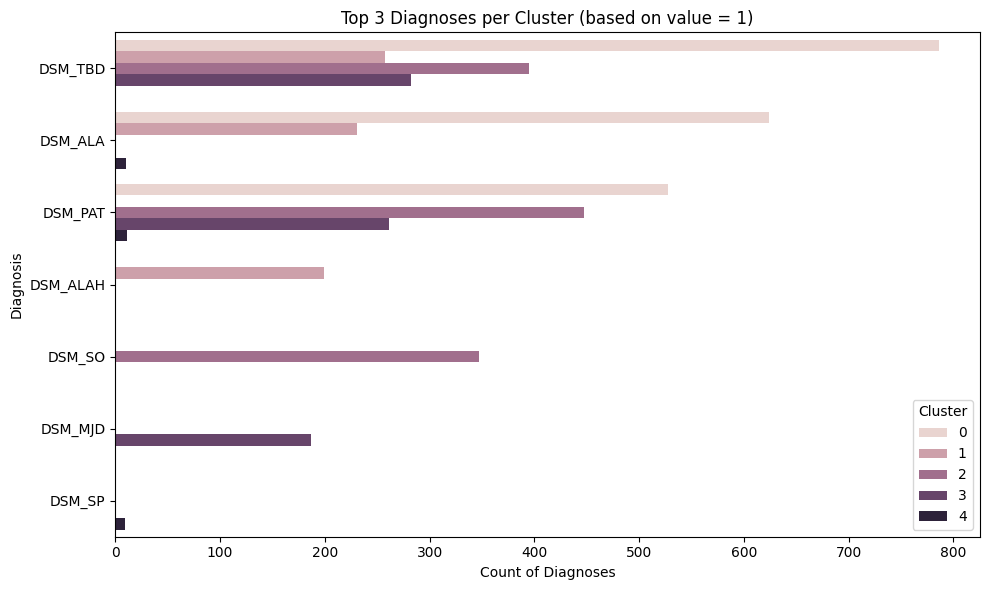

In [ ]:
long_df = diagnosis_counts.reset_index().melt(id_vars='cluster', var_name='diagnosis', value_name='count')

top3_long_df = (
    long_df
    .sort_values(['cluster', 'count'], ascending=[True, False])
    .groupby('cluster')
    .head(3)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top3_long_df,
    x='count',
    y='diagnosis',
    hue='cluster',
    dodge=True
)

plt.title('Top 3 Diagnoses per Cluster (based on value = 1)')
plt.xlabel('Count of Diagnoses')
plt.ylabel('Diagnosis')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()